In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image
from timm.models.swin_transformer import swin_tiny_patch4_window7_224
from torchvision.models import resnet18

# 🔹 Define the Multi-Scale CNN + Swin Transformer Model
class MultiScaleCNNSwinTransformer(nn.Module):
    def __init__(self):
        super(MultiScaleCNNSwinTransformer, self).__init__()
        self.cnn = resnet18(pretrained=True)
        self.cnn.fc = nn.Identity()
        self.swin_transformer = swin_tiny_patch4_window7_224(pretrained=True)
        self.swin_transformer.head = nn.Identity()
        self.fc = nn.Linear(768 + 512, 3)  # 3 classes: Normal, Immature, Mature

    def forward(self, x):
        cnn_features = self.cnn(x)  # [batch_size, 512]
        swin_features = self.swin_transformer.forward_features(x)  # [batch_size, seq_len, 768]
        swin_features = swin_features.mean(dim=[1, 2])  # Global pooling to [batch_size, 768]
        combined_features = torch.cat([cnn_features, swin_features], dim=1)
        return self.fc(combined_features)

# 🔹 Load the Pre-trained Model
model = MultiScaleCNNSwinTransformer()
model.load_state_dict(torch.load("multi_scale_cnn_swin_transformer1.pth", map_location=torch.device('cpu')))
model.eval()

c:\Users\prbac\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\prbac\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\prbac\AppData\Local\Temp\ipykernel_8344\132291234.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickli

MultiScaleCNNSwinTransformer(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [4]:
# 🔹 Class Labels
class_labels = ['Immature', 'Mature', 'Normal']

# 🔹 Select Target Layer for Grad-CAM
target_layer = model.cnn.layer4[-1]  # Last CNN layer

# 🔹 Define Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 🔹 Load Test Image
image_path = "C:/Users/prbac/Downloads/archive (1)/Dataset/test/Mature/aug_0_9851_jpeg.rf.ac5d2338290c4554c05cd78974f6bb45.jpg"  # Change this to your test image path
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension


🔹 Predicted Class: Mature
🔹 Probability: 0.9824


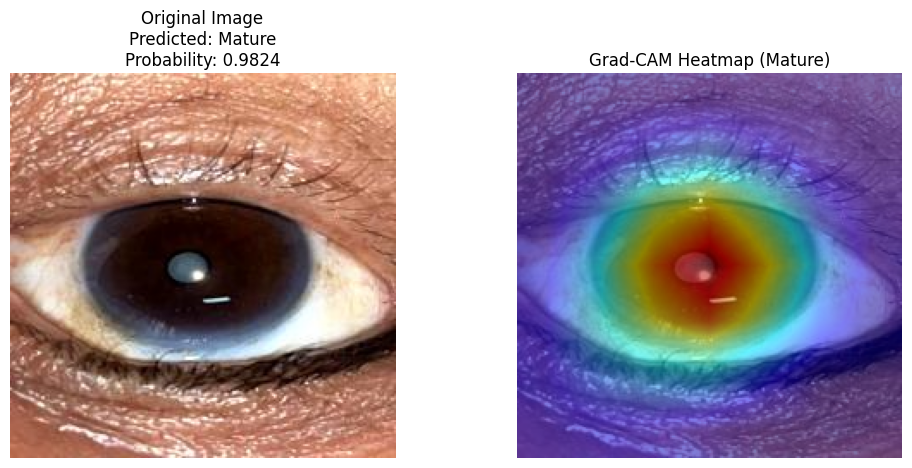

**Interpretation of the Grad-CAM Heatmap (Mature):**
**Red and Yellow Areas (High Attention):**
- The model focuses on the lens, detecting high opacity and cloudiness.
- This is characteristic of a mature cataract, where vision is significantly obstructed.

**Model Confidence:**
- Probability: 0.9824, indicating high confidence in classification.


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# 🔹 Make Prediction
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()
    prediction_label = class_labels[predicted_class]
    probability = torch.nn.functional.softmax(output, dim=1)[0][predicted_class].item()
    print(f"🔹 Predicted Class: {prediction_label}")
    print(f"🔹 Probability: {probability:.4f}")

# 🔹 Generate Grad-CAM Heatmap
cam = GradCAM(model=model, target_layers=[target_layer])
grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0]  # Extract heatmap

# Convert image to NumPy for visualization
image_np = np.array(image) / 255.0  # Normalize [0,1]
visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

# 🔹 Estimate Heatmap Focus Area
def estimate_heatmap_focus(heatmap):
    """
    Determines the primary region of focus in the Grad-CAM heatmap.
    """
    center_intensity = np.mean(heatmap[heatmap.shape[0]//3 : 2*heatmap.shape[0]//3,
                                       heatmap.shape[1]//3 : 2*heatmap.shape[1]//3])
    edge_intensity = np.mean(heatmap[:heatmap.shape[0]//4]) + np.mean(heatmap[-heatmap.shape[0]//4:])

    if center_intensity > edge_intensity * 1.5:
        return "lens"
    elif edge_intensity > center_intensity:
        return "periphery"
    else:
        return "cornea"

heatmap_focus = estimate_heatmap_focus(grayscale_cam)

# 🔹 Display Results
plt.figure(figsize=(12, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"Original Image\nPredicted: {prediction_label}\nProbability: {probability:.4f}")
plt.axis("off")

# Grad-CAM Heatmap
plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title(f"Grad-CAM Heatmap ({prediction_label})")
plt.axis("off")

plt.show()

def generate_gradcam_interpretation(pred_class, probability, heatmap_focus):
    """
    Generates an interpretation of a Grad-CAM heatmap for cataract classification.

    Parameters:
    pred_class (str): The predicted class label ("Mature", "Immature", "Normal").
    probability (float): Model confidence score.
    heatmap_focus (str): The primary region of the eye the heatmap highlights ("lens", "cornea", "periphery").

    Returns:
    str: A refined explanation of the Grad-CAM heatmap.
    """
    interpretation = [f"**Interpretation of the Grad-CAM Heatmap ({pred_class}):**"]

    if pred_class == "Normal":
        interpretation.append("**Model Focus Areas (Red/Yellow):**")
        if heatmap_focus == "lens":
            interpretation.append("- The model is verifying the clarity of the lens, which is a key feature of a normal eye.")
            interpretation.append("- The attention on the lens confirms that no significant opacity or clouding is detected.")
        else:
            interpretation.append("- The model is inspecting other parts of the eye, which might indicate some normal variations.")
        interpretation.append("\n**Low Attention Areas (Blue/Purple):**")
        interpretation.append("- The model is ignoring regions that are not significant for cataract detection, such as the sclera or eyelids.")
    
    elif pred_class == "Mature":
        interpretation.append("**Red and Yellow Areas (High Attention):**")
        interpretation.append("- The model focuses on the lens, detecting high opacity and cloudiness.")
        interpretation.append("- This is characteristic of a mature cataract, where vision is significantly obstructed.")
    
    elif pred_class == "Immature":
        interpretation.append("**Red and Yellow Areas (High Attention):**")
        interpretation.append("- The heatmap shows partial lens opacity, suggesting early-stage cataract formation.")
        interpretation.append("- The model detects mild clouding, but the eye retains some transparency.")

    interpretation.append("\n**Model Confidence:**")
    interpretation.append(f"- Probability: {probability:.4f}, indicating {'high' if probability > 0.9 else 'moderate'} confidence in classification.")

    return "\n".join(interpretation)

# Generate new interpretation
interpretation_text = generate_gradcam_interpretation(prediction_label, probability, heatmap_focus)
print(interpretation_text)

